Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Self-Supervised Learning

## Setup environment

## Setup imports

In [9]:
import os
import time
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch.nn import L1Loss
from torch.nn import TripletMarginLoss
from monai.utils import set_determinism, first
from monai.data import DataLoader, Dataset, CacheDataset
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    MapTransform,
)
import os
import glob
import logging
from importlib import reload
from ssl_head import SSLHead
from tripletLoss import TripletLoss

# print_config()

##### Define file paths & output directory path

In [10]:
root_dir = '../brats2021_flair_240_240_64/'
logdir_path = './log/'
roi_size = (128,128,64)

##### Create result logging directories, manage data paths & set determinism

In [11]:
if os.path.exists(logdir_path) is False:
    os.mkdir(logdir_path)
    
top_images = sorted(glob.glob(root_dir+"train/top/*mri.nii.gz"))
bottom_images = sorted(glob.glob(root_dir+"train/bottom/*mri.nii.gz"))
# train_labels = sorted(glob.glob(root_dir+"train/*seg.nii.gz"))

# data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
data_dicts_top = [{"image": image_name} for image_name in zip(top_images)]
data_dicts_bottom = [{"image": image_name} for image_name in zip(bottom_images)]

train_files_top, val_files_top = data_dicts_top[:240], data_dicts_top[240:300]
train_files_bottom, val_files_bottom = data_dicts_bottom[:240], data_dicts_bottom[240:300]
val_files = val_files_top + val_files_bottom
print(len(train_files_top),end='+')
print(len(train_files_bottom),end='+')
print(len(val_files))

# Set Determinism
set_determinism(seed=0)

240+240+120


##### Define MONAI Transforms 

In [12]:
class NormalizeFrom0to1(MapTransform):

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = (d[key] - torch.min(d[key])) / (torch.max(d[key]) - torch.min(d[key]))
        return d
    
# Define Training Transforms
train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Spacingd(keys=["image"], pixdim=(2.0, 2.0, 1.0), mode=("bilinear")),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=roi_size),
        NormalizeFrom0to1(keys=["image"]),
        CopyItemsd(keys=["image"], times=2, names=["gt_image", "image_2"], allow_missing_keys=False),
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=20
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image"], prob=0.8, holes=10, spatial_size=8),
        # Please note that that if image, image_2 are called via the same transform call because of the determinism
        # they will get augmented the exact same way which is not the required case here, hence two calls are made
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image_2"], prob=0.8, holes=10, spatial_size=8),
    ]
)

C:\Users\justin\Desktop\monai\MONAI\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


torch.Size([1, 1, 128, 128, 64])
image shape: torch.Size([128, 128, 64])
[0.0000000e+00 2.3058183e-30 3.7168417e-30 ... 9.9995738e-01 9.9997199e-01
 1.0000000e+00]


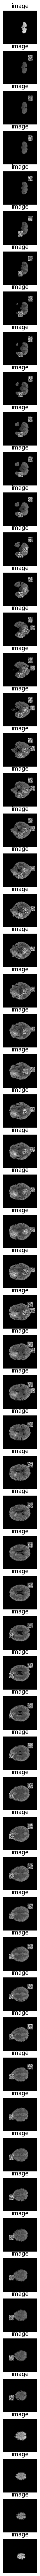

In [13]:
check_ds = Dataset(data=train_files_bottom, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
print(check_data["image"].shape)
image = (check_data["image"][0][0])
print(f"image shape: {image.shape}")
print(np.unique(image))
cols = 2
rows = image.shape[2]
fig = plt.figure("check", (4, 100))
for i in range(rows):
    fig.add_subplot(rows,cols,(i*cols)+1)
    plt.title("image")
    plt.imshow(image[:, :, i], cmap="gray")
    plt.axis('off')

##### Training Configuration

In [ ]:
# Training Config

# Define Network ViT backbone & Loss & Optimizer
device = torch.device("cuda:0")
# model = ViTAutoEnc(
#     in_channels=1,
#     img_size=roi_size,
#     patch_size=(16, 16, 16),
#     pos_embed="conv",
#     hidden_size=768,
#     mlp_dim=3072,
# )
model = SSLHead()

model = model.to(device)

# Define Hyper-paramters for training loop
max_epochs = 500
val_interval = 2
batch_size = 1
lr = 1e-4
epoch_loss_values = []
epoch_tri_loss_values = []
epoch_recon_loss_values = []
val_loss_values = []
best_val_loss = 1000.0

recon_loss = L1Loss()
triplet_loss = TripletMarginLoss(margin=1.0, p=2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Define DataLoader using MONAI, CacheDataset needs to be used
train_ds_top = CacheDataset(data=train_files_top, transform=train_transforms, cache_rate=1.0)
train_loader_top = DataLoader(train_ds_top, batch_size=batch_size, shuffle=True)

train_ds_bottom = CacheDataset(data=train_files_bottom, transform=train_transforms, cache_rate=1.0)
train_loader_bottom = DataLoader(train_ds_bottom, batch_size=batch_size, shuffle=True)

val_ds = CacheDataset(data=val_files, transform=train_transforms, cache_rate=1.0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

Loading dataset: 100%|██████████| 120/120 [00:26<00:00,  4.60it/s]


In [ ]:
# model.load_state_dict(torch.load(os.path.join('./log/best_model.pt')))
swinvit_dict = torch.load('./models/MRI/SwinVit-Triplet Loss+L1 Loss/best_model.pt')
swinvit_weights = swinvit_dict["state_dict"]
model.load_state_dict(swinvit_weights)

<All keys matched successfully>

##### Training loop with validation

In [ ]:
#reload logger
logging.shutdown()
reload(logging)
logging.basicConfig(filename=logdir_path+'training_log.txt',filemode='a',format='%(message)s',level=logging.DEBUG)

for epoch in range(109,max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_tri_loss = 0
    epoch_recon_loss = 0
    step = 0    
    start_time = time.time()

    train_ds_size = len(train_ds_top) + len(train_ds_bottom)

    for (batch_data_top, batch_data_bottom) in zip(train_loader_top, train_loader_bottom):
        step += 1

        anchor_input, positive_input, gt_input = (
            batch_data_top["image"].to(device),
            batch_data_top["image_2"].to(device),
            batch_data_top["gt_image"].to(device),
        )
        negative_input = batch_data_bottom["image"].to(device)

        optimizer.zero_grad()

        anchor = model(anchor_input)
        positive = model(positive_input)
        negative = model(negative_input)

        r_loss = recon_loss(anchor, gt_input)
        tri_loss = triplet_loss(anchor, positive, negative)

        total_loss = r_loss + tri_loss * r_loss

        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()

        epoch_tri_loss += tri_loss.item()
        epoch_recon_loss += r_loss.item()

        print(
            f"{step}/{train_ds_size // train_loader_top.batch_size}, "
            f"train_loss: {total_loss.item():.4f}"
            f" | tri_loss: {tri_loss.item():.4f}"
            f" | recon_loss: {r_loss.item():.4f}"
        )

    for (batch_data_top, batch_data_bottom) in zip(train_loader_top, train_loader_bottom):
        step += 1

        anchor_input, positive_input, gt_input = (
            batch_data_bottom["image"].to(device),
            batch_data_bottom["image_2"].to(device),
            batch_data_bottom["gt_image"].to(device),
        )
        negative_input = batch_data_top["image"].to(device)

        optimizer.zero_grad()

        anchor = model(anchor_input)
        positive = model(positive_input)
        negative = model(negative_input)

        r_loss = recon_loss(anchor, gt_input)
        tri_loss = triplet_loss(anchor, positive, negative)

        total_loss = r_loss + tri_loss * r_loss

        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()

        epoch_tri_loss += tri_loss.item()
        epoch_recon_loss += r_loss.item()

        print(
            f"{step}/{train_ds_size // train_loader_top.batch_size}, "
            f"train_loss: {total_loss.item():.4f}"
            f" | tri_loss: {tri_loss.item():.4f}"
            f" | recon_loss: {r_loss.item():.4f}"
        )
    

    epoch_loss /= step
    epoch_tri_loss /= step
    epoch_recon_loss /= step

    epoch_loss_values.append(epoch_loss)
    epoch_tri_loss_values.append(epoch_tri_loss)
    epoch_recon_loss_values.append(epoch_recon_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    logging.info(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if epoch % val_interval == 0:
        print("Entering Validation for epoch: {}".format(epoch + 1))
        total_val_loss = 0
        val_step = 0
        model.eval()
        for val_batch in val_loader:
            val_step += 1
            inputs, gt_input = (
                val_batch["image"].to(device),
                val_batch["gt_image"].to(device),
            )
            print("Input shape: {}".format(inputs.shape))
            outputs = model(inputs)
            val_loss = recon_loss(outputs, gt_input)
            total_val_loss += val_loss.item()

        total_val_loss /= val_step
        val_loss_values.append(total_val_loss)
        print(f"epoch {epoch + 1} Validation avg loss: {total_val_loss:.4f}")

        if total_val_loss < best_val_loss:
            print(f"Saving new model based on validation loss {total_val_loss:.4f}")
            logging.info(f"Saving new model based on validation loss {total_val_loss:.4f}")
            best_val_loss = total_val_loss
            checkpoint = {"epoch": max_epochs, "state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            torch.save(checkpoint, os.path.join(logdir_path, "best_model.pt"))
        
        if epoch%100==0:
            checkpoint = {"epoch": max_epochs, "state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            torch.save(checkpoint, os.path.join(logdir_path, f"epoch_{epoch}_model.pt"))

        plt.figure(1, figsize=(8, 8))
        plt.subplot(2, 2, 1)
        plt.plot(epoch_loss_values)
        plt.grid()
        plt.title("Training Loss")

        plt.subplot(2, 2, 2)
        plt.plot(val_loss_values)
        plt.grid()
        plt.title("Validation Loss")

        plt.subplot(2, 2, 3)
        plt.plot(epoch_tri_loss_values)
        plt.grid()
        plt.title("Training Triplet Loss")

        plt.subplot(2, 2, 4)
        plt.plot(epoch_recon_loss_values)
        plt.grid()
        plt.title("Training Recon Loss")

        plt.savefig(os.path.join(logdir_path, "loss_plots.png"))
        plt.close(1)    

    end_time = time.time()
    print(f"time taken: {end_time-start_time}s")
print("Done")